# Identifying Disadvantaged Counties in the USA

## Methodology 

After starting to work with the data available on https://screeningtool.geoplatform.gov/en/methodology, we wanted to get a better idea of how which states and counties are most disadvantaged. 

We also wanted to give users the ability to explore those locations interactively based on user-set thresholds. 

Starting with the basics, we've created a tool that lets you identify which counties contain the most disadvantaged communities according to any of the disadvantaged critieria available. (c.f. https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) 


In [3]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [4]:
import pandas as pd
import sys

from ipywidgets import interact, interact_manual
import ipywidgets as widgets
from IPython.display import HTML, display


sys.path.append("../..")
pd.options.display.max_rows = 500
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 100


display(HTML('''<style>
    .widget-label { min-width: 20ex !important; }
</style>'''))

from  sage_one_tree_planted.data.climate_and_economic_justice_dataset import ClimateAndEconomicJusticeDataset
c = ClimateAndEconomicJusticeDataset()
c.fetch_data()

In [6]:
df2=pd.read_csv(c.screening_data/"communities-2022-05-06-1838GMT.csv")
df_disadvantaged_communities = df2[df2["Identified as disadvantaged"] == True]
df_disadvantaged_communities.groupby(["County Name", "State/Territory"])["Identified as disadvantaged"]\
    .count().to_frame().sort_values("Identified as disadvantaged", ascending=False).head(100)

total_census_tracts_df = df2.groupby(["County Name", "State/Territory",])["Census tract ID"].count()

@interact(top_results=(10,500,10), total_census_tracts=(1, 1000, 1))
def show_more_disadvantaged_counties(top_results=10,  total_census_tracts=2, normalize=False):
    if not normalize:
        filtered = df_disadvantaged_communities.groupby(["County Name", "State/Territory"])["Identified as disadvantaged"]\
    .count().to_frame().join(total_census_tracts_df).rename(columns={"Census tract ID":"Total Census Tracts"}).sort_values("Identified as disadvantaged", ascending=False).reset_index()
        return filtered[filtered["Total Census Tracts"] >= total_census_tracts ].head(top_results)
    else: 
        with_totals_df = df2.groupby(["County Name", "State/Territory", "Identified as disadvantaged"])[["Identified as disadvantaged"]].count()
        with_totals_df.columns = ["count"]
        with_total_df = with_totals_df.join(total_census_tracts_df)
        with_total_df["Percent of Census Tracts Identified as Disadvantaged"] = 100 * with_total_df["count"] / with_total_df["Census tract ID"]
        with_total_df.reset_index(inplace=True)
        with_total_df.rename(columns={"Census tract ID":"Total Census Tracts"}, inplace=True)
        filtered  = with_total_df[with_total_df["Identified as disadvantaged"]  == True][["County Name", "State/Territory","Total Census Tracts", "Percent of Census Tracts Identified as Disadvantaged" ]]\
.sort_values("Percent of Census Tracts Identified as Disadvantaged", ascending=False)
        
        return filtered[filtered["Total Census Tracts"] >= total_census_tracts ].reset_index().head(top_results)

interactive(children=(IntSlider(value=10, description='top_results', max=500, min=10, step=10), IntSlider(valu…

 Assuming we are getting the filtered list from the above user-defined configuration, below is how we can start adding some interactive/static map

In [7]:
df_tmp = show_more_disadvantaged_counties(top_results=10,  total_census_tracts=2, normalize=False)

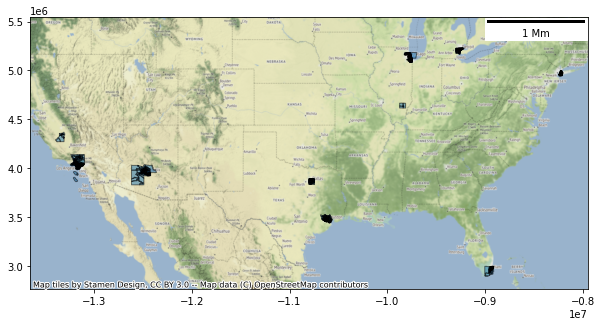

In [8]:
import geopandas as gpd
usa_locations = gpd.read_file(c.shape_file/"usa.shp")
df_tmp.rename(columns={"County Name":"CF", "State/Territory":"SF"}, inplace=True)
usa_filtered_locations = usa_locations[(usa_locations["SF"].isin(set(df_tmp["SF"].tolist()))) & \
                                       (usa_locations["CF"].isin(set(df_tmp["CF"].tolist())))]
usa_filtered_locations_wm = usa_filtered_locations.to_crs(epsg=3857)
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar

ax = usa_filtered_locations_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)
ax.add_artist(ScaleBar(1))

In [9]:
def _is_disadvantaged_group(df):
    return df[df["Identified as disadvantaged"] == True]



In [10]:
df_disadvantaged_group = _is_disadvantaged_group(df=df2)

In [11]:
COLUMNS_FILTER = df2.columns.tolist()[3:]

In [12]:
COLUMNS_FILTER.remove("Identified as disadvantaged")

In [13]:
def _compute_mean(df, columns):
    return df.groupby(["County Name", "State/Territory"])[columns].mean().reset_index()


In [14]:
df_mean =_compute_mean(df=df_disadvantaged_group, columns=COLUMNS_FILTER)

In [15]:
df_mean.head()

,County Name,State/Territory,Total threshold criteria exceeded,Total categories exceeded,Total population,Is low income and high percent of residents that are not higher ed students?,"Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and high percent of residents that are not higher ed students?",Expected agricultural loss rate (Natural Hazards Risk Index) (percentile),Expected agricultural loss rate (Natural Hazards Risk Index),"Greater than or equal to the 90th percentile for expected building loss rate, is low income, and high percent of residents that are not higher ed students?",Expected building loss rate (Natural Hazards Risk Index) (percentile),Expected building loss rate (Natural Hazards Risk Index),"Greater than or equal to the 90th percentile for expected population loss rate, is low income, and high percent of residents that are not higher ed students?",Expected population loss rate (Natural Hazards Risk Index) (percentile),Expected population loss rate (Natural Hazards Risk Index),"Greater than or equal to the 90th percentile for energy burden, is low income, and high percent of residents that are not higher ed students?",Energy burden (percentile),Energy burden,"Greater than or equal to the 90th percentile for PM2.5 exposure, is low income, and high percent of residents that are not higher ed students?",PM2.5 in the air (percentile),PM2.5 in the air,"Greater than or equal to the 90th percentile for diesel particulate matter, is low income, and high percent of residents that are not higher ed students?",Diesel particulate matter exposure (percentile),Diesel particulate matter exposure,"Greater than or equal to the 90th percentile for traffic proximity, is low income, and high percent of residents that are not higher ed students?",Traffic proximity and volume (percentile),Traffic proximity and volume,"Greater than or equal to the 90th percentile for housing burden, is low income, and high percent of residents that are not higher ed students?",Housing burden (percent) (percentile),Housing burden (percent),"Greater than or equal to the 90th percentile for lead paint, the median house value is less than 90th percentile, is low income, and high percent of residents that are not higher ed students?",Percent pre-1960s housing (lead paint indicator) (percentile),Percent pre-1960s housing (lead paint indicator),Median value ($) of owner-occupied housing units (percentile),Median value ($) of owner-occupied housing units,"Greater than or equal to the 90th percentile for proximity to hazardous waste facilities, is low income, and high percent of residents that are not higher ed students?",Proximity to hazardous waste sites (percentile),Proximity to hazardous waste sites,"Greater than or equal to the 90th percentile for proximity to superfund sites, is low income, and high percent of residents that are not higher ed students?",Proximity to NPL (Superfund) sites (percentile),Proximity to NPL (Superfund) sites,"Greater than or equal to the 90th percentile for proximity to RMP sites, is low income, and high percent of residents that are not higher ed students?",Proximity to Risk Management Plan (RMP) facilities (percentile),Proximity to Risk Management Plan (RMP) facilities,"Greater than or equal to the 90th percentile for wastewater discharge, is low income, and high percent of residents that are not higher ed students?",Wastewater discharge (percentile),Wastewater discharge,"Greater than or equal to the 90th percentile for asthma, is low income, and high percent of residents that are not higher ed students?",Current asthma among adults aged greater than or equal to 18 years (percentile),Current asthma among adults aged greater than or equal to 18 years,"Greater than or equal to the 90th percentile for diabetes, is low income, and high percent of residents that are not higher ed students?",Diagnosed diabetes among adults aged greater than or equal to 18 years (percentile),Diagnosed 

In [16]:
@interact
def _rank_by_column(column=COLUMNS_FILTER, topN=10):
    df_mean["max_rank"] = df_mean.groupby("State/Territory")[column].rank(method="max")
    return df_mean[df_mean["max_rank"] <= topN]

interactive(children=(Dropdown(description='column', options=('Total threshold criteria exceeded', 'Total cate…

In [18]:
@interact
def _plot_rank_locations(column=COLUMNS_FILTER, topN=10):
    df_rank_result = _rank_by_column(column=column, topN=topN)
    df_rank_result.rename(columns={"County Name":"CF", "State/Territory":"SF"}, inplace=True)
    usa_filtered_locations = usa_locations[(usa_locations["SF"].isin(set(df_rank_result["SF"].tolist()))) & \
                                           (usa_locations["CF"].isin(set(df_rank_result["CF"].tolist())))]
    usa_filtered_locations_wm = usa_filtered_locations.to_crs(epsg=3857)
    ax = usa_filtered_locations_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
    cx.add_basemap(ax)
    ax.add_artist(ScaleBar(1))

interactive(children=(Dropdown(description='column', options=('Total threshold criteria exceeded', 'Total cate…

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

STATES=list(df2["State/Territory"].unique())

@interact
def _plot_column_by_state(state=STATES, column=COLUMNS_FILTER, topN=10):
    df_rank_result = _rank_by_column(column=column, topN=topN)
    data = df_rank_result[df_rank_result["State/Territory"]==state]
    ax=sns.catplot(x="County Name", y=column, data=data, kind="bar", 
                   col="State/Territory", col_wrap=4, order=data["County Name"])
    plt.xticks(rotation=90)


interactive(children=(Dropdown(description='state', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Cali…